In [1]:
#imports 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import os

/home/guillaumelevy/Documents/WorldLLM/.venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
#Load the data
baselines_to_load = ["playground_metropolis_phi_phi","playground_metropolis_phi_phi_wt5"]
baselines_names = ["M", "M2"]
all_data = {k: [] for k in baselines_names}
all_rules = {}
all_likelihoods = {}
all_weights = {}
all_additional_data = {}
for baseline, b_name in zip(baselines_to_load, baselines_names):
    print("-------------------------------- Load " + baseline + " --------------------------------")
    path_start = "./outputs/" + baseline + "/"
    lst_data = []
    for f_day in os.listdir(path_start):
        if os.path.isdir(path_start + f_day):
            for f_hour in os.listdir(path_start + f_day):
                if os.path.isdir(path_start + f_day + "/" + f_hour):
                    path = path_start + f_day + "/" + f_hour + "/all.json"
                    with open(path, "r") as file:
                        lst_data.append(json.load(file))
                        print("Loaded: " + path)
    # Reconstruct all rules and parse by seeds
    if "counts" in lst_data[0]["metrics"]:
        # Parse IS
        rules = []
        likelihoods = []
        weights = []
        for data in lst_data:
            rules.append(np.repeat(data["rules"], data["metrics"]["counts"]))
            likelihoods.append(np.repeat(data["metrics"]["test_likelihoods"], data["metrics"]["counts"]))
            weights.append(np.repeat(data["metrics"]["weights"], data["metrics"]["counts"]))
        all_rules[b_name] = np.stack(rules)
        all_likelihoods[b_name] = np.stack(likelihoods)
        all_weights[b_name] = np.stack(weights)
    elif "prev_rules_ind" in lst_data[0]["metrics"]:
        # Parse Metropolis
        # Reconstruct all rules M
        reshaped_rules = []
        reshaped_likelihoods = []
        reshaped_weights = []
        reshaped_prev_rules_ind = []
        for data in lst_data:
            #TODO: remove hardcoded default rule to 3
            nb_particles = data["metrics"]["nb_rules"] if "nb_rules" in data["metrics"] else 3
            rules = np.array(data["rules"])
            likelihoods = np.array(data["metrics"]["test_likelihoods"])
            weights = np.array(data["metrics"]["weights"])
            prev_rules_ind = np.array(data["metrics"]["prev_rules_ind"])
            reshaped_rules.append(rules.reshape((-1, nb_particles)).transpose())
            reshaped_likelihoods.append(likelihoods.reshape((-1, nb_particles)).transpose())
            reshaped_weights.append(weights.reshape((-1, nb_particles)).transpose())
            reshaped_prev_rules_ind.append(prev_rules_ind.reshape((-1, nb_particles)).transpose())
        # Concatenate all seeds
        all_rules[b_name] = np.concatenate(reshaped_rules, axis=0)
        all_likelihoods[b_name] = np.concatenate(reshaped_likelihoods, axis=0)
        all_weights[b_name] = np.concatenate(reshaped_weights, axis=0)
        all_additional_data[b_name] = {"prev_rules_ind": np.concatenate(reshaped_prev_rules_ind, axis=0)}
    else:
        raise ValueError("Unknown format")
    all_data[b_name] = lst_data

-------------------------------- Load playground_metropolis_phi_phi --------------------------------
Loaded: ./outputs/playground_metropolis_phi_phi/2024-09-13/01-38-02_439/all.json
Loaded: ./outputs/playground_metropolis_phi_phi/2024-09-13/01-21-57_438/all.json
-------------------------------- Load playground_metropolis_phi_phi_wt5 --------------------------------
Loaded: ./outputs/playground_metropolis_phi_phi_wt5/2024-09-13/02-02-44_439/all.json
Loaded: ./outputs/playground_metropolis_phi_phi_wt5/2024-09-13/01-55-15_438/all.json


In [3]:
# Compare best rule for IS and M
# Best rules of each method
best_taken = 50
all_baselines_name = list(all_likelihoods.keys())
all_best_rules_ind = []
for b_name in all_baselines_name:
    best_rules_ind = np.argsort(-all_likelihoods[b_name].flatten())[:best_taken]
    all_best_rules_ind.append(best_rules_ind)
likelihoods = np.concatenate([all_likelihoods[b_name].flatten()[all_best_rules_ind[incr]] for incr, b_name in enumerate(all_baselines_name)])
rules = np.concatenate([all_rules[b_name].flatten()[all_best_rules_ind[incr]] for incr, b_name in enumerate(all_baselines_name)])
indices = np.argsort(-likelihoods)
all_colors_start = ["\033[31m", "\033[32m", "\033[34m", "\033[35m", "\033[36m", "\033[37m", "\033[33m", "\033[90m"]
all_colors_end = ["\033[0m"] * len(all_colors_start)
all_colors_names = ["Red", "Green", "Blue", "Magenta", "Cyan", "White", "Yellow", "Bright Black"]
# Print colors for every baselines:
print("Colors for each baselines:")
for incr, b_name in enumerate(all_baselines_name):
    print(f"Baseline: '{b_name}' Color: {all_colors_start[incr]}{all_colors_names[incr]}{all_colors_end[incr]}")
for incr, ind in enumerate(indices):
    color_start = all_colors_start[ind//best_taken]
    color_end = all_colors_end[ind//best_taken]
    print(
        f"{color_start}-----rule-----:{incr}: {repr(rules[ind])}, likelihood: {likelihoods[ind]:2f}{color_end}"
    )

Colors for each baselines:
Baseline: 'M' Color: Red
Baseline: 'M2' Color: Green
-----rule-----:0: '1. Object and Water: Object transforms into the object (e.g., "You go to the water. o: You are standing on water a: You give the water. o: The water and carrot seed transform into the carrot.").\n\n2. Water and Plant/Berry/Potato/Carrot: Transforms the water into the plant, berry, potato, or carrot, respectively. (e.g., "a: You go to the water. o: You are standing on water a: You pick up the object. o: You are holding the water. a: You go to the carrot seed. o: You are standing on carrot seed a: You give the water. o: The water and carrot seed transform into the carrot.")\n\n3. Herbivore and Water: Except for baby rhinoceros, changes into another herbivore. (e.', likelihood: -153.865112
-----rule-----:1: '1. **Water and Water:** Result in water (e.g., "a: You go to the water. o: You are standing on water a: You pick up the object. o: You are holding the water.").\n\n2. **Water and Plant/B

In [4]:
# Number of sames rules per particle
for b_name in all_baselines_name:
    redudant_rules = [len(all_rules[b_name][particle])- len(set(all_rules[b_name][particle])) for particle in range(all_rules[b_name].shape[0])]
    print(f"Number of same rules per particle for {b_name}: {redudant_rules}")

Number of same rules per particle for M: [1, 0, 0, 0, 0, 0]
Number of same rules per particle for M2: [6, 43, 14, 37, 63, 14]


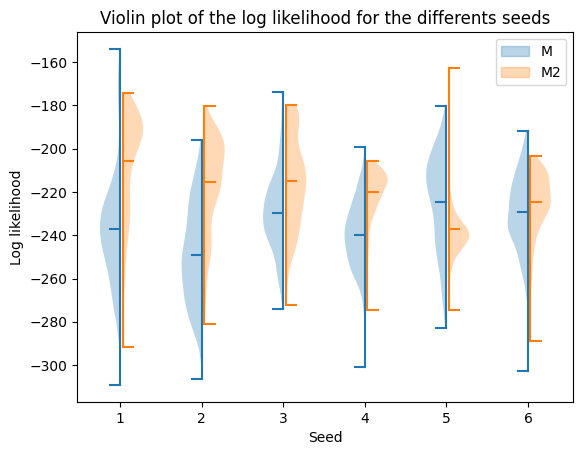

In [5]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
for b_name in all_baselines_name[1:]:
    plt.figure()
    color1 = plt.violinplot(all_likelihoods[all_baselines_name[0]].transpose(), showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
    color1 = matplotlib.patches.Patch(color=color1)
    color2 = plt.violinplot(all_likelihoods[b_name].transpose(), showmeans=True, side="high", positions=[i+1.03 for i in range(len(all_likelihoods[b_name]))])["bodies"][0].get_facecolor().flatten()
    color2 = matplotlib.patches.Patch(color=color2)
    plt.legend([color1, color2], [all_baselines_name[0], b_name])
    plt.title("Violin plot of the log likelihood for the differents seeds")
    plt.xlabel("Seed")
    plt.ylabel("Log likelihood")
    plt.show()

# Embeddings

In [6]:
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(np.concatenate([all_rules[b_name].flatten() for b_name in all_baselines_name], axis=0))

### t-SNE

In [7]:
#Compute the t-SNE embeddings
proj_embeddings = TSNE(n_components=2).fit_transform(embeddings)

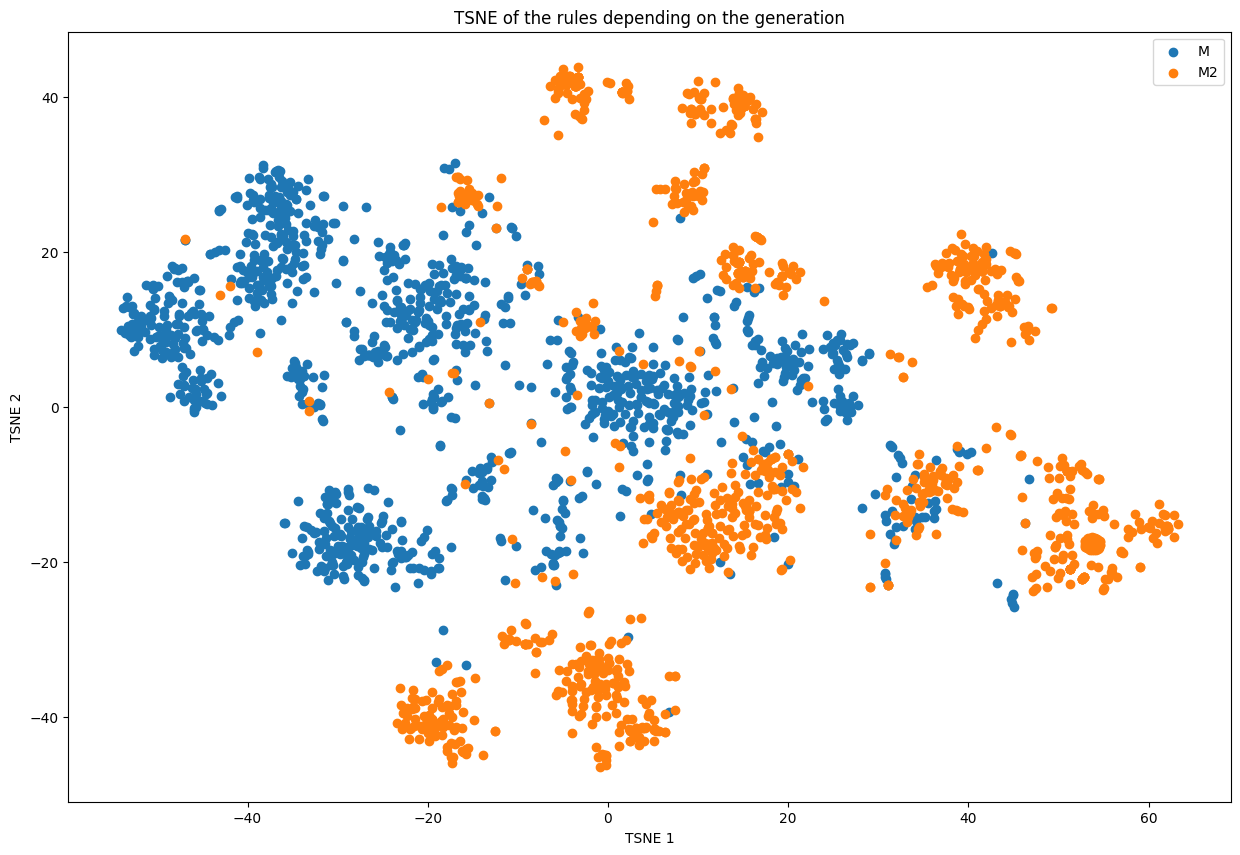

In [8]:
# Plot the embeddings
plt.figure(figsize=(15,10))
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    plt.scatter(proj_embeddings[start_index:start_index+len(all_rules[b_name].flatten()),0], proj_embeddings[start_index:start_index+len(all_rules[b_name].flatten()),1], label=b_name)
    start_index = start_index + len(all_rules[b_name].flatten())
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

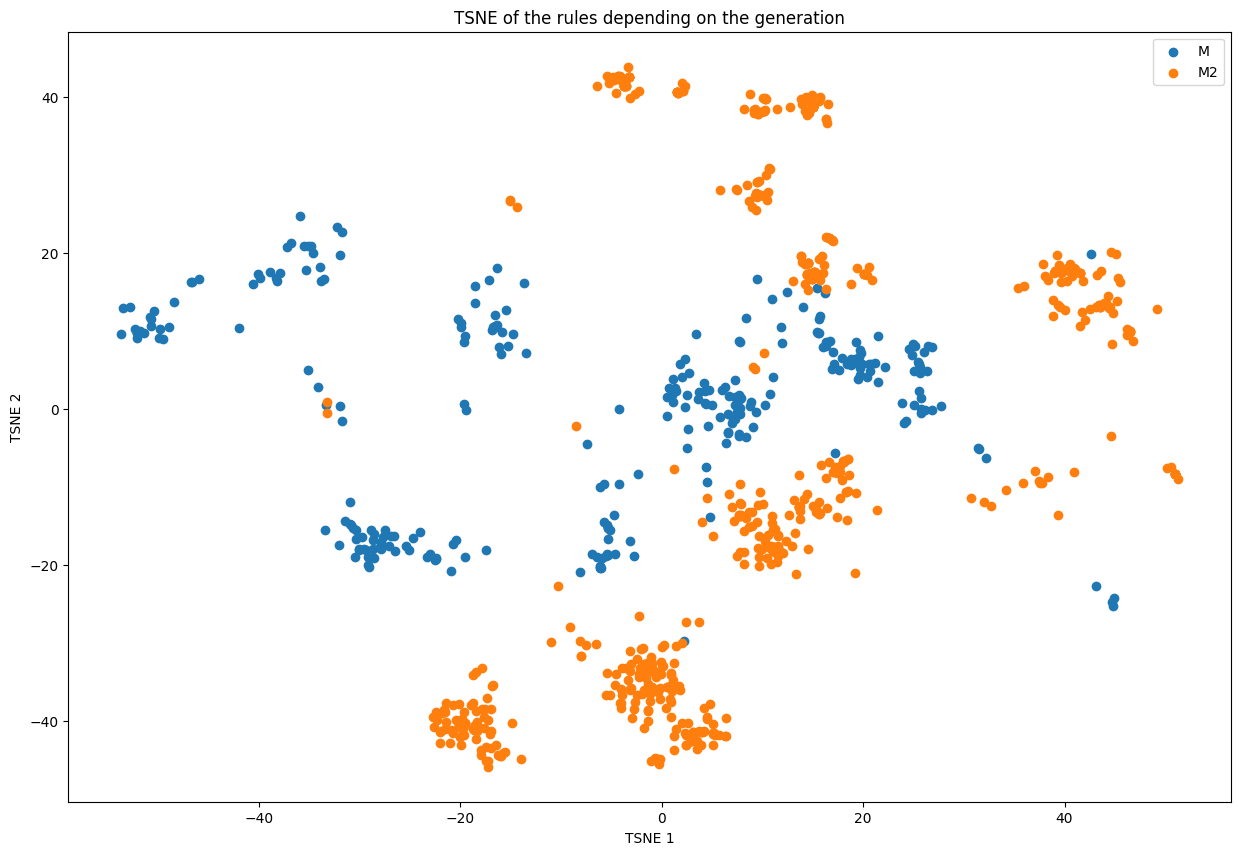

In [9]:
# Plot embeddings with likelihoods high enough
# Plot the embeddings
plt.figure(figsize=(15,10))
likelihoods = np.concatenate([all_likelihoods[b_name].flatten() for b_name in all_baselines_name])
mask_likelihood = likelihoods > -220
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    mask_index = (np.arange(len(likelihoods))<start_index+len(all_rules[b_name].flatten())) & (np.arange(len(likelihoods))>=start_index)
    plt.scatter(proj_embeddings[mask_index & mask_likelihood,0], proj_embeddings[mask_index & mask_likelihood,1], label=b_name)
    start_index = start_index + len(all_rules[b_name].flatten())
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()